# Epoch Model Energy Score
Training a epoch-level model on EEG data to predict next day energy score.

In [32]:
# %reload_ext autoreload
# %autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [33]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [34]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)

df = stitch_pipeline_results.stitch_all_days_optimised(input_dir)

  0%|          | 0/112 [00:00<?, ?it/s]

C:\dev\play\brainwave-processor\stitch_pipeline_results.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return post_stitch(pd.concat(all_dfs))


In [35]:
# import stitch_pipeline_results
# from importlib import reload
# reload(stitch_pipeline_results)
#
# df = stitch_pipeline_results.post_stitch(df)


In [36]:
cols = [col for col in df.columns if col.startswith("SleepStage") or col == 'Timestamp']
cols

['Timestamp',
 'SleepStageDeep',
 'SleepStageWake',
 'SleepStageN1',
 'SleepStageN2',
 'SleepStageR',
 'SleepStagePreReadyToSleep',
 'SleepStageDuringReadyToSleep',
 'SleepStageAfterSleep',
 'SleepStageAfterWake']

In [37]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [38]:
useful_day_data = day_data[['dayAndNightOf', 'energy:energyScore']]

In [39]:
useful_day_data

,dayAndNightOf,energy:energyScore
0,2024-04-21,NaN
1,2024-04-22,NaN
2,2024-04-23,NaN
3,2024-04-24,NaN
4,2024-04-25,NaN
...,...,...
239,2024-12-16,28.422081
240,2024-12-17,32.919094
241,2024-12-18,25.151099
242,2024-12-19,17.500000


In [40]:
merged = df.merge(useful_day_data, on='dayAndNightOf')

In [41]:
# merged.columns

In [42]:
# [col for col in merged.columns if "SleepStage" in col]


In [43]:
grouped = merged.groupby('dayAndNightOf').agg(
    energy=('energy:energyScore', 'mean'),
).reset_index()
grouped

In [13]:
# grouped

,dayAndNightOf,energy
0,2024-07-08,NaN
1,2024-07-11,20.000000
2,2024-07-12,NaN
3,2024-07-13,NaN
4,2024-07-14,80.000000
...,...,...
90,2024-12-14,35.889423
91,2024-12-16,28.422081
92,2024-12-17,32.919094
93,2024-12-18,25.151099


In [44]:
grouped['energy'].describe()

count     74.000000
mean      40.649858
std       24.903323
min       10.000000
25%       20.000000
50%       35.282161
75%       50.000000
max      120.000000
Name: energy, dtype: float64

# Prepare data

In [15]:
# list(merged.columns)

['Stage',
 'Confidence',
 'Epoch',
 'Timestamp',
 'Source',
 'F8-M1_Stage',
 'F8-M1_Confidence',
 'T4-M1_Stage',
 'T4-M1_Confidence',
 'O2-M1_Stage',
 'O2-M1_Confidence',
 'StageInt',
 'F8-M1_eeg_abspow',
 'F8-M1_eeg_abspow_c7min_norm',
 'F8-M1_eeg_abspow_p2min_norm',
 'F8-M1_eeg_alpha',
 'F8-M1_eeg_alpha_c7min_norm',
 'F8-M1_eeg_alpha_p2min_norm',
 'F8-M1_eeg_alphaaa',
 'F8-M1_eeg_alphaaa_c7min_norm',
 'F8-M1_eeg_alphaaa_p2min_norm',
 'F8-M1_eeg_alphaab',
 'F8-M1_eeg_alphaab_c7min_norm',
 'F8-M1_eeg_alphaab_p2min_norm',
 'F8-M1_eeg_alphaabs',
 'F8-M1_eeg_alphaabs_c7min_norm',
 'F8-M1_eeg_alphaabs_p2min_norm',
 'F8-M1_eeg_alphaabsaa',
 'F8-M1_eeg_alphaabsaa_c7min_norm',
 'F8-M1_eeg_alphaabsaa_p2min_norm',
 'F8-M1_eeg_alphaabsab',
 'F8-M1_eeg_alphaabsab_c7min_norm',
 'F8-M1_eeg_alphaabsab_p2min_norm',
 'F8-M1_eeg_at',
 'F8-M1_eeg_at_c7min_norm',
 'F8-M1_eeg_at_p2min_norm',
 'F8-M1_eeg_auc',
 'F8-M1_eeg_auc_c7min_norm',
 'F8-M1_eeg_auc_p2min_norm',
 'F8-M1_eeg_beta',
 'F8-M1_eeg_beta_c7m

In [45]:
# merged.index

In [53]:
import sys
from importlib import reload
import models.util.features
reload(models.util.features)
import epoch_model_energy_score
reload(epoch_model_energy_score)

models_and_data = epoch_model_energy_score.create_and_add_all(merged, False)

from models.final_wake.final_wake_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.1, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

NaN indices: [    0     1     2 ... 71143 71144 71145] (23854 total of 103009)
Infinity indices: []
Too large indices: []
CleanTargetCol (103009, 1625) to (79155, 1625)
Condition (79155, 1625) to (79155, 1625)
FeaturesHandler (79155, 1625) to (79155, 1625) Had 1625 features, after filtering have features ['Epoch', 'HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_auc_c7min_norm

In [47]:
# [col for col in models_and_data[0].X if col.startswith("SleepStage") or col == 'Timestamp']
# #

# Train XGBoost model

In [54]:
from models.util.rfe_training import train_rfe
from models.util.evaluation import evaluate_regression_model_quick
from dataclasses import dataclass
import xgboost as xgb
from sklearn.feature_selection import RFE
import models.util.importances as importances
from importlib import reload
reload(importances)


for md in models_and_data:
    def get_model():
        if md.is_classifier:
            model = xgb.XGBClassifier(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
            )
        else:
            model = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
            )
        return (model, {
            "source": "xgb"
        })

    md.models = train_rfe(get_model, md.name, md.X_train, md.y_train, md.X_val, md.y_val)


import memory
memory.garbage_collect(print)

import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)



Training RFE model for energyBestEEG with 140 features... RMSE train: 3.8429005634422593 RMSE val: 6.166303953178427
Training RFE model for energyBestEEG with 70 features... RMSE train: 3.900598202713155 RMSE val: 5.990834940300327
Training RFE model for energyBestEEG with 35 features... RMSE train: 4.047734962541084 RMSE val: 5.834977521498609
Training RFE model for energyBestEEG with 17 features... RMSE train: 4.509762936972109 RMSE val: 6.2971717809806
Training RFE model for energyBestEEG with 8 features... RMSE train: 4.9981930890222666 RMSE val: 6.490523288651842
Training RFE model for energyBestEEG with 4 features... RMSE train: 8.855198861818888 RMSE val: 10.08743358961272
Memory Usage: 3421.10 MB GC to 3287.96 MB


<module 'models.util.evaluation' from 'C:\\dev\\play\\brainwave-processor\\models\\util\\evaluation.py'>

In [55]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_regression_models(models_and_data)

,Rows_Train,MAE_Train,MAE_Val,MSE_Train,MSE_Val,RMSE_Train,RMSE_Val,Model,n_features,source
0,71239,2.525501,3.663893,14.767885,38.023304,3.842901,6.166304,energyBestEEG,140,xgb
1,71239,2.534157,3.559275,15.214666,35.890103,3.900598,5.990835,energyBestEEG,70,xgb
2,71239,2.575563,3.434576,16.384158,34.046963,4.047735,5.834978,energyBestEEG,35,xgb
3,71239,2.904990,3.747710,20.337962,39.654372,4.509763,6.297172,energyBestEEG,17,xgb
4,71239,3.200564,3.863891,24.981934,42.126893,4.998193,6.490523,energyBestEEG,8,xgb
5,71239,5.924398,6.642976,78.414547,101.756316,8.855199,10.087434,energyBestEEG,4,xgb


In [56]:
bm = models_and_data[0].models[4]
bst = bm.model
bm

ModelAndSettings(model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), X_train=        minsSinceLEP   Temp  minsUntilWakeActual  minsSinceGotIntoBed  \
60216     134.180094    NaN           317.503239           145.746761   
16921     100.048580  36.60           423.951420            95.765246   
27545  

# Most useful features

In [31]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Plot the 0th tree
#xgb.to_graphviz(bst, num_trees=1)
# plt.show()


In [57]:
# Install SHAP if you haven't already
# !pip install shap

import shap
import xgboost as xgb

# Create a DMatrix for SHAP
# dmatrix = xgb.DMatrix(bm.X_train)

# Initialize the SHAP explainer
explainer = shap.Explainer(bm.model)

# Calculate SHAP values
shap_values = explainer(bm.X_train)

shap_values.shape

(71239, 8)

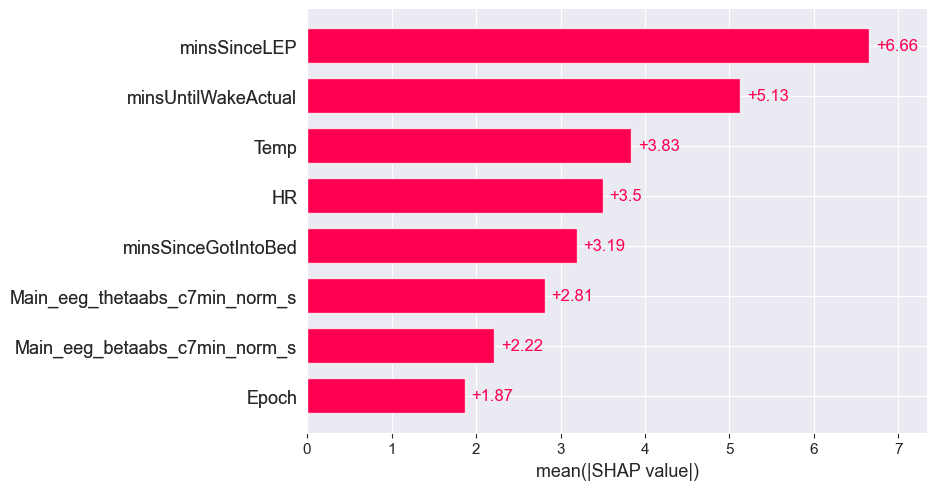

In [58]:
shap.plots.bar(shap_values, max_display=20)


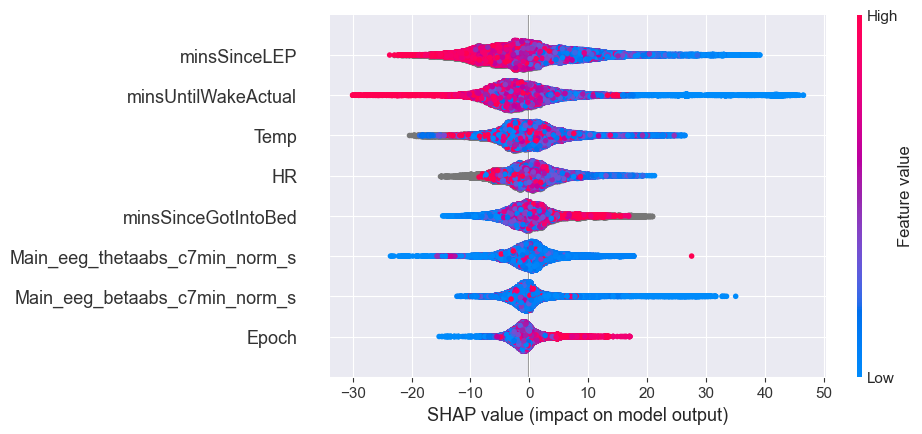

In [59]:
shap.plots.beeswarm(shap_values, max_display=20)


In [60]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Get the indices of the top 16 features
top_features_indices = np.argsort(mean_abs_shap_values)[-16:][::-1]

# Get the names of the top 16 features
top_features = [shap_values.feature_names[i] for i in top_features_indices]

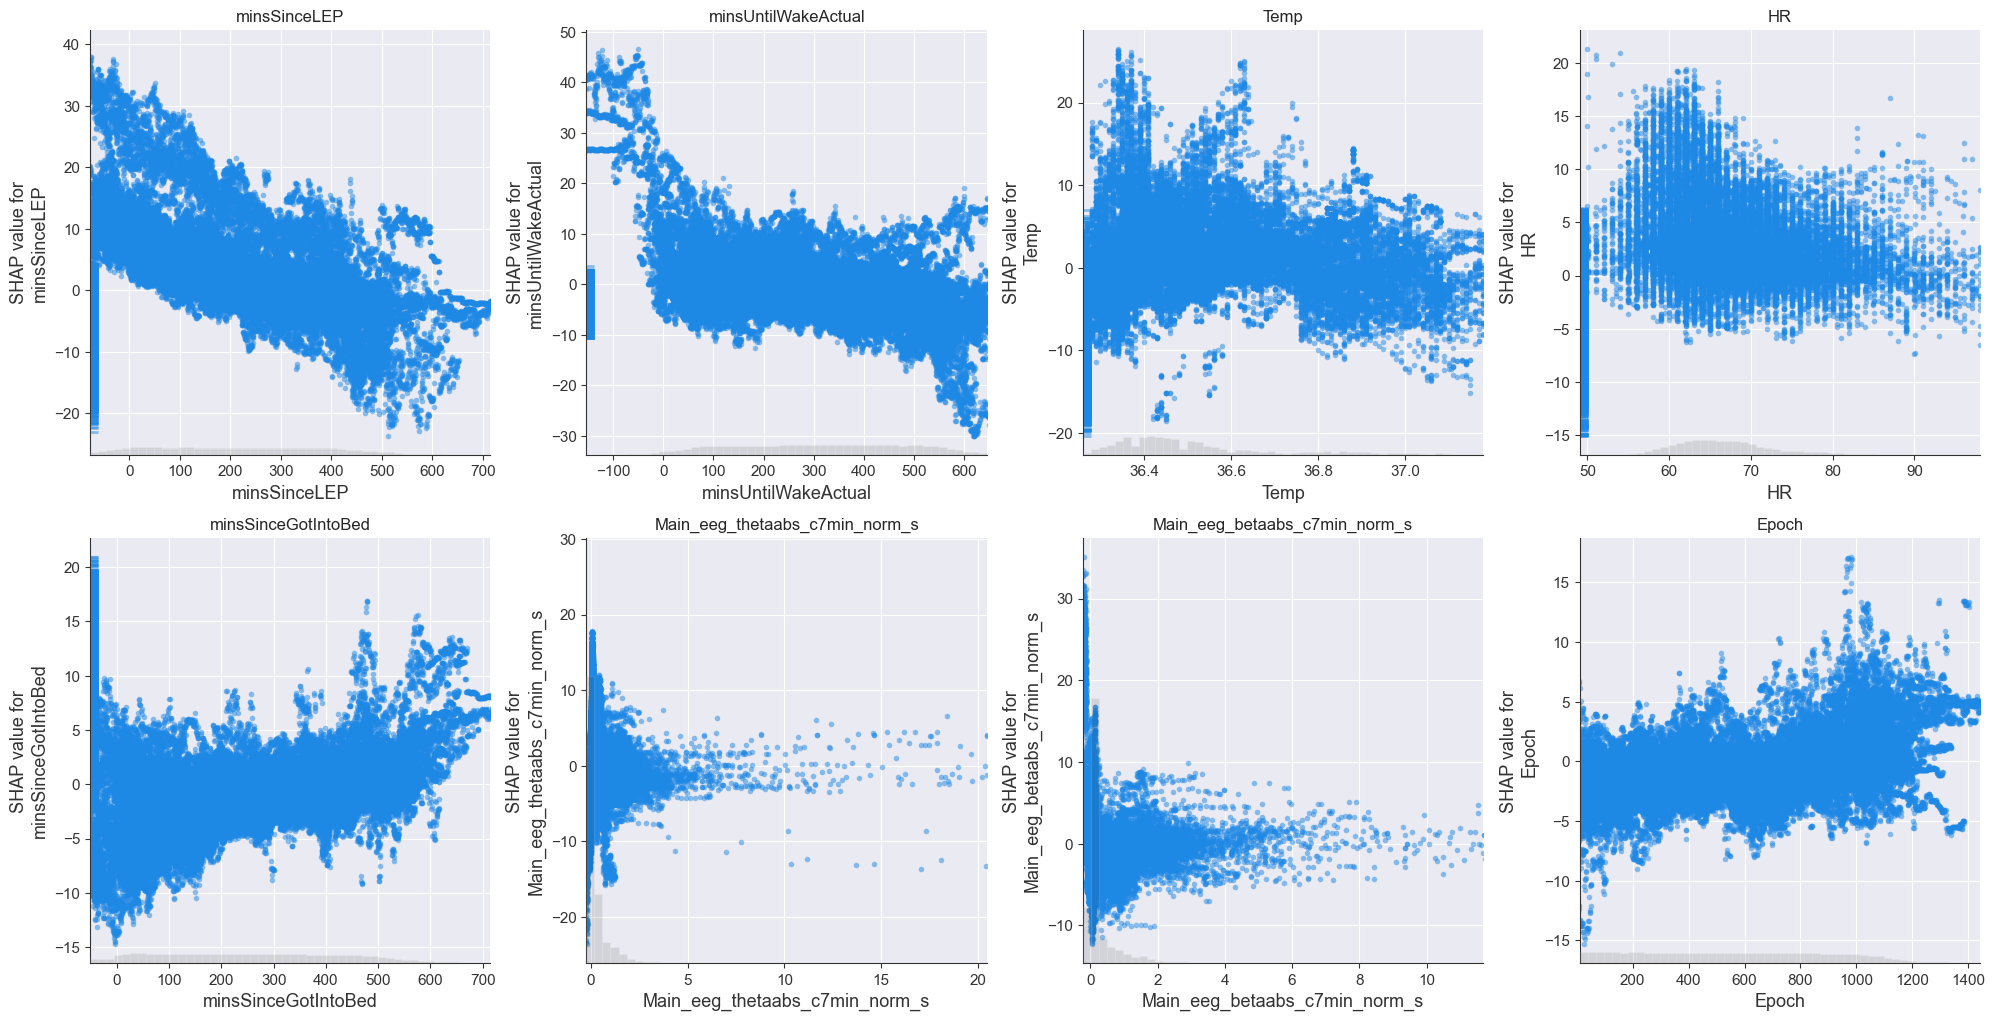

In [61]:
import matplotlib.pyplot as plt
import shap

# Create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(top_features):
    shap.plots.scatter(shap_values[:, feature], ax=axes[i], show=False, xmin='percentile(1)', xmax='percentile(99)', alpha=0.5)  # Avoid triggering plt.show()
    axes[i].set_title(feature)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [85]:
bst.features_

AttributeError: 'XGBRegressor' object has no attribute 'features_'

In [89]:
list(bm.X_train.columns)

['HR',
 'Temp',
 'Main_eeg_abspow_c7min_norm_s',
 'HrvRMSSDSomewhatRecent',
 'Main_eeg_alpha_c7min_norm_s',
 'Main_eeg_thetaabs_c7min_norm_s',
 'Main_eeg_petrosian_c7min_norm_s',
 'Main_eeg_fdelta_c7min_norm_s',
 'Main_eeg_alphaabs_c7min_norm_s',
 'Main_eeg_ds_c7min_norm_s',
 'Main_eeg_betaabs_c7min_norm_s',
 'Main_eeg_dt_c7min_norm_s',
 'Main_eeg_abspow_p2min_norm_s',
 'Main_eeg_betaabs_s',
 'Main_eeg_sigmaabs_c7min_norm_s',
 'Main_eeg_betaabs_p2min_norm_s',
 'Main_eeg_theta_c7min_norm_s']

In [90]:
models_and_data[1].X[list(bm.X_train.columns)]

,HR,Temp,Main_eeg_abspow_c7min_norm_s,HrvRMSSDSomewhatRecent,Main_eeg_alpha_c7min_norm_s,Main_eeg_thetaabs_c7min_norm_s,Main_eeg_petrosian_c7min_norm_s,Main_eeg_fdelta_c7min_norm_s,Main_eeg_alphaabs_c7min_norm_s,Main_eeg_ds_c7min_norm_s,Main_eeg_betaabs_c7min_norm_s,Main_eeg_dt_c7min_norm_s,Main_eeg_abspow_p2min_norm_s,Main_eeg_betaabs_s,Main_eeg_sigmaabs_c7min_norm_s,Main_eeg_betaabs_p2min_norm_s,Main_eeg_theta_c7min_norm_s
310,NaN,NaN,2.656300,NaN,-0.018084,3.329717,1.100909,1.261927,2.022071,0.614693,2.072377,0.311701,1.156316,0.275163,2.521393,0.434733,0.258172
311,NaN,NaN,2.707459,NaN,-0.021005,3.329170,1.110693,1.255783,2.042126,0.603395,2.132278,0.325606,1.226914,0.617302,2.593536,0.685398,0.231838
312,NaN,NaN,2.796325,NaN,-0.026354,3.352909,1.113602,1.272967,2.067444,0.609096,2.210647,0.343692,2.949525,3.515174,2.683673,2.184350,0.202100
313,NaN,NaN,2.730726,NaN,-0.029652,3.302551,1.114491,1.338984,2.013477,0.622612,2.194414,0.345786,2.914965,4.886686,2.640221,3.436238,0.186361
314,NaN,NaN,2.654851,NaN,-0.034197,3.240304,1.110590,1.444815,1.919636,0.652993,2.058842,0.353358,3.673383,2.438768,2.452689,4.228810,0.173081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94848,NaN,NaN,1.159311,NaN,-0.002812,0.574046,0.992656,1.059200,0.509268,0.527646,0.264763,0.619314,1.261447,0.625330,0.424968,0.320261,0.337823
94849,NaN,NaN,1.014461,NaN,0.029243,0.572416,0.993834,1.161033,0.501326,0.473925,0.248842,0.438063,0.869233,0.373463,0.403060,0.273335,0.417678
94850,NaN,NaN,0.867670,NaN,0.062111,0.567626,0.997514,1.245354,0.489987,0.425226,0.232333,0.262538,0.759701,0.479337,0.378280,0.277116,0.497101
94851,NaN,NaN,0.712494,NaN,0.100518,0.537937,0.997655,1.267046,0.467536,0.376310,0.211814,0.189706,0.747278,0.365871,0.351510,0.213971,0.574253


In [91]:
all_predicted = bst.predict(models_and_data[1].X[list(bm.X_train.columns)])

In [93]:
all_predicted.shape

(71361,)

In [97]:
all_predicted

array([26.8334  , 23.98292 , 23.850082, ..., 34.89345 , 35.115116,
       37.03033 ], dtype=float32)

In [114]:
models_and_data[0].X

,HR,HrvRMSSDSomewhatRecent,Main_eeg_abspow_c7min_norm_s,Main_eeg_abspow_p2min_norm_s,Main_eeg_abspow_s,Main_eeg_alpha_c7min_norm_s,Main_eeg_alpha_p2min_norm_s,Main_eeg_alpha_s,Main_eeg_alphaaa_c7min_norm_s,Main_eeg_alphaaa_p2min_norm_s,...,SleepStageAfterSleep,SleepStageAfterWake,SleepStageDeep,SleepStageDuringReadyToSleep,SleepStageN1,SleepStageN2,SleepStagePreReadyToSleep,SleepStageR,SleepStageWake,Temp
310,NaN,NaN,2.656300,1.156316,0.719453,-0.018084,0.002578,0.049254,0.021284,-0.033922,...,False,False,False,0.0,False,False,True,False,True,NaN
311,NaN,NaN,2.707459,1.226914,0.806000,-0.021005,0.013736,0.069564,0.024949,-0.000624,...,False,False,False,0.0,False,False,True,False,True,NaN
312,NaN,NaN,2.796325,2.949525,3.930379,-0.026354,-0.019744,-0.032004,0.025709,-0.013046,...,False,False,False,0.0,False,False,True,False,True,NaN
313,NaN,NaN,2.730726,2.914965,1.733877,-0.029652,-0.014366,0.048515,0.027037,0.064741,...,False,False,False,0.0,False,False,True,False,True,NaN
314,NaN,NaN,2.654851,3.673383,2.578959,-0.034197,-0.030490,-0.009443,0.017337,0.069756,...,False,False,False,0.0,False,False,True,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94848,NaN,NaN,1.159311,1.261447,1.160756,-0.002812,-0.068607,-0.015529,0.067024,0.042381,...,True,True,False,0.0,False,False,False,False,True,NaN
94849,NaN,NaN,1.014461,0.869233,0.351627,0.029243,-0.022194,0.122088,0.095556,0.085367,...,True,True,False,0.0,False,False,False,False,True,NaN
94850,NaN,NaN,0.867670,0.759701,0.601344,0.062111,0.015267,0.069726,0.125282,0.117023,...,True,True,False,0.0,False,False,False,False,True,NaN
94851,NaN,NaN,0.712494,0.747278,0.242295,0.100518,0.035965,0.167343,0.161245,0.069537,...,True,True,False,0.0,False,False,False,False,True,NaN


In [117]:
garbage_collect(print)

Memory Usage: 173.97 MB GC to 611.49 MB


In [119]:
x = pd.DataFrame()
x['Prediction'] = bst.predict(models_and_data[0].X[list(bm.X_train.columns)])
x['Label'] = models_and_data[0].y
x['PredictionError'] = x['Prediction'] - x['Label']
x['PredictionErrorAbs'] = x['PredictionError'].abs()
# x.index = models_and_data[0].X.index
# x['Timestamp'] = df['Timestamp']
x

,Prediction,Label,PredictionError,PredictionErrorAbs
0,26.833401,NaN,NaN,NaN
1,23.982920,NaN,NaN,NaN
2,23.850082,NaN,NaN,NaN
3,22.952454,NaN,NaN,NaN
4,22.196785,NaN,NaN,NaN
...,...,...,...,...
71356,34.597126,50.454145,-15.857019,15.857019
71357,33.774223,50.454145,-16.679921,16.679921
71358,34.893452,50.454145,-15.560693,15.560693
71359,35.115116,50.454145,-15.339029,15.339029


In [109]:

x[x['Label'].notna()]

,Prediction,Label,PredictionError,PredictionErrorAbs
310,18.701347,20.000000,-1.298653,1.298653
311,21.811781,20.000000,1.811781,1.811781
312,20.789219,20.000000,0.789219,0.789219
313,19.984056,20.000000,-0.015944,0.015944
314,20.891867,20.000000,0.891867,0.891867
...,...,...,...,...
71356,34.597126,50.454145,-15.857019,15.857019
71357,33.774223,50.454145,-16.679921,16.679921
71358,34.893452,50.454145,-15.560693,15.560693
71359,35.115116,50.454145,-15.339029,15.339029


In [108]:
x['PredictionErrorAbs'].describe()

count    47869.000000
mean        26.884881
std         23.820577
min          0.000004
25%          5.782738
50%         22.076950
75%         37.624557
max        119.855453
Name: PredictionErrorAbs, dtype: float64

In [110]:
x['Prediction'].describe()

count    71361.000000
mean        42.739376
std         25.312975
min          3.582364
25%         21.930355
50%         35.898388
75%         50.401356
max        139.855453
Name: Prediction, dtype: float64

In [152]:
day = '2024-12-19'
df_for_day = merged[merged['dayAndNightOf'] == day]
df_for_day.shape

(1052, 1625)

In [154]:
models_and_data_for_day = epoch_model_energy_score.create_and_add_all(df_for_day, True)


NaN indices: [] (0 total of 1052)
Infinity indices: []
Too large indices: []
Condition: before 1052 rows after 1052 rows
Had 1625 features, after filtering have features ['HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_at_c7min_norm_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_auc_c7min_norm_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_beta_c7min

In [161]:
predictions_for_day = bm.model.predict(models_and_data_for_day[1].X[list(bm.X_train.columns)])

In [164]:
predictions_for_day = pd.DataFrame(predictions_for_day, columns=['Prediction'])

In [166]:
predictions_for_day.describe()

,Prediction
count,1052.000000
mean,20.324787
std,4.058536
min,10.227100
25%,17.592905
50%,19.364652
75%,22.380981
max,42.704594


In [186]:
from importlib import reload
import models.util.features
reload(models.util.features)
import epoch_model_energy_score
reload(epoch_model_energy_score)

models_and_data_all_days = epoch_model_energy_score.create_and_add_all(merged, True)


NaN indices: [    0     1     2 ... 71143 71144 71145] (23854 total of 103009)
Infinity indices: []
Too large indices: []
CleanTargetCol (103009, 1625) to (79155, 1625)
Condition (79155, 1625) to (79155, 1625)
FeaturesHandler (79155, 1625) to (79155, 1625) Had 1625 features, after filtering have features ['HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_auc_c7min_norm_s', 'Mai

In [185]:
# models_and_data_all_days[0].X

,HR,HrvRMSSDSomewhatRecent,Main_eeg_abspow_c7min_norm_s,Main_eeg_abspow_p2min_norm_s,Main_eeg_abspow_s,Main_eeg_alpha_c7min_norm_s,Main_eeg_alpha_p2min_norm_s,Main_eeg_alpha_s,Main_eeg_alphaaa_c7min_norm_s,Main_eeg_alphaaa_p2min_norm_s,...,SleepStageAfterWake,SleepStageDeep,SleepStageDuringReadyToSleep,SleepStageN1,SleepStageN2,SleepStagePreReadyToSleep,SleepStageR,SleepStageWake,Temp,energy:energyScore
310,NaN,NaN,2.656300,1.156316,0.719453,-0.018084,0.002578,0.049254,0.021284,-0.033922,...,False,False,0.0,False,False,True,False,True,NaN,20.0
311,NaN,NaN,2.707459,1.226914,0.806000,-0.021005,0.013736,0.069564,0.024949,-0.000624,...,False,False,0.0,False,False,True,False,True,NaN,20.0
312,NaN,NaN,2.796325,2.949525,3.930379,-0.026354,-0.019744,-0.032004,0.025709,-0.013046,...,False,False,0.0,False,False,True,False,True,NaN,20.0
313,NaN,NaN,2.730726,2.914965,1.733877,-0.029652,-0.014366,0.048515,0.027037,0.064741,...,False,False,0.0,False,False,True,False,True,NaN,20.0
314,NaN,NaN,2.654851,3.673383,2.578959,-0.034197,-0.030490,-0.009443,0.017337,0.069756,...,False,False,0.0,False,False,True,False,True,NaN,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103004,NaN,NaN,1.882935,1.217863,0.421761,0.038438,0.112063,0.051629,0.069405,0.115022,...,True,False,0.0,False,False,False,False,True,36.49,17.5
103005,NaN,NaN,2.174298,1.222186,1.318201,0.030473,0.103478,-0.056848,0.064467,0.109615,...,True,False,0.0,False,False,False,False,True,36.49,17.5
103006,NaN,NaN,2.525197,0.881676,0.937233,0.028109,0.102168,-0.035050,0.066370,0.115064,...,True,False,0.0,False,False,False,False,True,36.49,17.5
103007,NaN,NaN,3.012034,3.691706,15.751330,0.024945,0.095607,-0.072372,0.067748,0.124130,...,True,False,0.0,False,False,False,False,True,36.49,17.5


In [183]:
# merged[merged['dayAndNightOf'] == '2024-12-19']['energy:energyScore'].head()

101957    17.5
101958    17.5
101959    17.5
101960    17.5
101961    17.5
Name: energy:energyScore, dtype: float64

In [199]:
predictions_all_days = pd.DataFrame(bm.model.predict(models_and_data_all_days[0].X[list(bm.X_train.columns)]), columns=['Prediction'])
predictions_all_days.index = models_and_data_all_days[0].X.index


In [189]:
display(predictions_all_days.shape)
display(models_and_data_all_days[0].X.shape)

(79155, 1)

(79155, 132)

In [200]:
merged_all_days = merged.merge(predictions_all_days, left_index=True, right_index=True)

In [197]:
predictions_all_days.index = models_and_data_all_days[0].X.index

In [198]:
predictions_all_days.index

Index([   310,    311,    312,    313,    314,    315,    316,    317,    318,
          319,
       ...
       102999, 103000, 103001, 103002, 103003, 103004, 103005, 103006, 103007,
       103008],
      dtype='int64', length=79155)

In [201]:
merged.iloc[-1]

Stage                                                             W
Confidence                                                 0.999386
Epoch                                                          1051
Timestamp                       2024-12-20 06:04:18.872128010+00:00
Source                                                       Fpz-M1
                                               ...                 
SleepStagePreReadyToSleep                                     False
SleepStageDuringReadyToSleep                                    0.0
SleepStageAfterSleep                                           True
SleepStageAfterWake                                            True
energy:energyScore                                             17.5
Name: 103008, Length: 1625, dtype: object

In [191]:
merged_all_days.iloc[-1]

Stage                                                            N1
Confidence                                                 0.615782
Epoch                                                           363
Timestamp                       2024-11-27 00:37:16.945585966+00:00
Source                                                       Fpz-M1
                                               ...                 
SleepStageDuringReadyToSleep                                    0.0
SleepStageAfterSleep                                           True
SleepStageAfterWake                                           False
energy:energyScore                                        36.074424
Prediction                                                20.778204
Name: 79154, Length: 1626, dtype: object

In [202]:
grouped = merged_all_days.groupby('dayAndNightOf').agg(
    EnergyActual=('energy:energyScore', 'mean'),
    EnergyPrediction=('Prediction', 'mean'),
).reset_index()
grouped['EnergyPredictionError'] = grouped['EnergyActual'] - grouped['EnergyPrediction']
grouped['EnergyPredictionErrorAbs'] = grouped['EnergyPredictionError'].abs()
grouped

,dayAndNightOf,EnergyActual,EnergyPrediction,EnergyPredictionError,EnergyPredictionErrorAbs
0,2024-07-11,20.000000,21.282183,-1.282183,1.282183
1,2024-07-14,80.000000,77.060562,2.939438,2.939438
2,2024-07-15,100.000000,96.253845,3.746155,3.746155
3,2024-07-16,20.000000,22.619358,-2.619358,2.619358
4,2024-07-21,100.000000,97.356544,2.643456,2.643456
...,...,...,...,...,...
69,2024-12-14,35.889423,36.440918,-0.551495,0.551495
70,2024-12-16,28.422081,29.512629,-1.090548,1.090548
71,2024-12-17,32.919094,34.097614,-1.178521,1.178521
72,2024-12-18,25.151099,27.323898,-2.172799,2.172799
